<a href="https://colab.research.google.com/github/dongzooo/Quant-with-py/blob/main/%EC%BA%94%EB%93%A4%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%B6%84%EC%84%9D/ETF%ED%94%84%EB%A1%9C%EA%B7%B8%EB%9E%A8_%EB%A7%A4%EC%88%98%ED%83%80%EC%9D%B4%EB%B0%8D_%EB%B3%80%EC%88%98_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# # 폰트 설치 : 글자 깨지면 런타임 재실행
# !pip install yfinance --quiet
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [1]:
import yfinance as yf
import pandas as pd
import datetime
from google.colab import files

import seaborn as snsWWW
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import Logit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')

# 유니코드에서  음수 부호설정
matplotlib.rc('axes', unicode_minus=False)

In [ ]:
files.upload()

In [3]:
#14시50분 이후 데이터는 날리는 작업은 이평성 생성후 한다
target_time = pd.to_datetime("14:50:00", format="%H:%M:%S").strftime('%H:%M:%S')
# index -> 1: Kodex Lev 2: 인버스 x2, 3: 코스닥 레버, 4: 코스닥 인버

In [4]:
#수익률 설정 변수
target_return = 0.005 #0.005

#### 1) 수익여부 알고리즘 돌리는 함수

In [15]:
# 수익나는 변곡시점 찾는 알고리즘 : 3분봉 5이평 변곡시 30분봉 5이평, 10분봉 10이평이 우상향일 때 매수, 0.5%이익이면 익절, 전봉저가 이탈&0.5%손실
def buyFindInflection(n, df, col_name):
    turning_points = []
    loss_points = []
    start_num = n + 1
    for i in range(start_num, len(df)):
      buyPrice = 0
      # 변곡 발생
      if (df[col_name].iloc[i] > df[col_name].iloc[i - 1] <= df[col_name].iloc[i - 2]):
        if df['30Min5MA'].iloc[i] == 1 and df['10Min10MA'].iloc[i] == 1 :
          buyPrice = df['Close'].iloc[i]
          targetPrice = buyPrice + (buyPrice*target_return)
          stopLossPrice = buyPrice - (buyPrice*target_return)
          #매수 시물레이션
          for j in range(i,len(df)) :
            # 손절 조건: 현봉저가가 전봉저가보다 낮아지면
            if df['Low'].iloc[j] < df['Low'].iloc[j-1] and df['Close'].iloc[j] <= stopLossPrice:
                loss_points.append(i)
                break
            #익절조건
            elif df['Close'].iloc[j] >= targetPrice :
                turning_points.append(i)
                break
    return turning_points, loss_points

#### 2) 변곡 찾는 함수


In [16]:
# 변곡발생만 검색
def findInflection(n, df, col_name):
    turning_points = []
    start_num = n + 1
    for i in range(start_num, len(df)):
      # 변곡 발생
      if (df[col_name].iloc[i] > df[col_name].iloc[i - 1] <= df[col_name].iloc[i - 2]):
              turning_points.append(i)
    return turning_points

#### 3) 최종결과 함수

In [28]:
def getDfReult(i):
    df1Min = pd.read_csv(f"/content/ytd1MinData{i}.csv")
    df1Min = df1Min.drop(df1Min.columns[0], axis=1)
    df1Min.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close','Volume']
    df1Min['Timestamp'] = pd.to_datetime(df1Min['Timestamp'], format="%y-%m-%d %H:%M:%S")
    df1Min = df1Min.drop_duplicates().sort_values('Timestamp').reset_index(drop=True)

    df3Min = pd.read_csv(f"/content/ytd3MinData{i}.csv")
    df3Min = df3Min.drop(df3Min.columns[0], axis=1)
    df3Min.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close','Volume']
    df3Min['Timestamp'] = pd.to_datetime(df3Min['Timestamp'], format="%y-%m-%d %H:%M:%S")
    df3Min = df3Min.drop_duplicates().sort_values('Timestamp').reset_index(drop=True)

    df10Min = pd.read_csv(f"/content/ytd10MinData{i}.csv")
    df10Min = df10Min.drop(df10Min.columns[0], axis=1)
    df10Min.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close','Volume']
    df10Min['Timestamp'] = pd.to_datetime(df10Min['Timestamp'], format="%y-%m-%d %H:%M:%S")
    df10Min = df10Min.drop_duplicates().sort_values('Timestamp').reset_index(drop=True)

    df30Min = pd.read_csv(f"/content/ytd30MinData{i}.csv")
    df30Min = df30Min.drop(df30Min.columns[0], axis=1)
    df30Min.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close','Volume']
    df30Min['Timestamp'] = pd.to_datetime(df30Min['Timestamp'], format="%y-%m-%d %H:%M:%S")
    df30Min = df30Min.drop_duplicates().sort_values('Timestamp').reset_index(drop=True)

    # 3분봉 이평선 생성
    df3Min['5MA'] = df3Min['Close'].rolling(window=5).mean()
    # df3Min['Return'] = df3Min['Close'].pct_change() * 100
    df3Min.head()
    # df3Min['MA_Crossover'] = df3Min['Moving Average'].diff().shift(-1).fillna(0).apply(lambda x: 1 if x > 0 else -1 if x < 0 else 0)

    df10Min['10MA'] = df10Min['Close'].rolling(window=10).mean()
    df30Min['5MA'] = df30Min['Close'].rolling(window=5).mean()
    #3,10,30분봉과 1분봉 시계열 시작 맞추기
    df1Min['Timestamp'].iloc[0]
    df3Min = df3Min[df3Min['Timestamp'] >= df1Min['Timestamp'].iloc[0]]
    df3Min = df3Min.reset_index(drop=True)

    df10Min = df10Min[df10Min['Timestamp'] >= df1Min['Timestamp'].iloc[0]]
    df10Min['10MA우상향'] = df10Min['10MA'].pct_change().apply(lambda x: 1 if x >= 0 else 0)
    df10Min = df10Min.reset_index(drop=True)

    df30Min = df30Min[df30Min['Timestamp'] >= df1Min['Timestamp'].iloc[0]]
    df30Min['5MA우상향'] = df30Min['5MA'].pct_change().apply(lambda x: 1 if x > 0 else 0)
    df30Min = df30Min.reset_index(drop=True)

    # 1분봉 이동평균선 계산
    df1Min['3MA'] = df1Min['Close'].rolling(window=3).mean()
    df1Min['5MA'] = df1Min['Close'].rolling(window=5).mean()
    df1Min['10MA'] = df1Min['Close'].rolling(window=10).mean()
    df1Min['20MA'] = df1Min['Close'].rolling(window=20).mean()
    df1Min['60MA'] = df1Min['Close'].rolling(window=60).mean()

    # 1분봉 거래이평 우상향 계산
    df1Min['5VMA'] = df1Min['Volume'].rolling(window=5).mean()
    df1Min['5VMA우상향'] = df1Min['5VMA'].pct_change()
    df1Min['5VMA우상향'] = df1Min['5VMA우상향'].apply(lambda x: 1 if x > 0 else 0)

    #1분봉 이동평균선 계산
    df1Min['5&10이격'] = ((df1Min['5MA'] - df1Min['10MA']) / df1Min['10MA']) * 100
    df1Min['전봉5&10이격'] = df1Min['5&10이격'].shift(1)
    df1Min['전봉5&10이격'].fillna(0, inplace=True)

    #우상향여부
    df1Min['3MA우상향'] = df1Min['3MA'].pct_change()
    df1Min['5MA우상향'] = df1Min['5MA'].pct_change()
    df1Min['10MA우상향'] = df1Min['10MA'].pct_change()
    df1Min['20MA우상향'] = df1Min['20MA'].pct_change()
    df1Min['60MA우상향'] = df1Min['60MA'].pct_change()

    df1Min['3MA우상향'] = df1Min['3MA우상향'].apply(lambda x: 1 if x > 0 else 0)
    df1Min['5MA우상향'] = df1Min['5MA우상향'].apply(lambda x: 1 if x > 0 else 0)
    df1Min['10MA우상향'] = df1Min['10MA우상향'].apply(lambda x: 1 if x > 0 else 0)
    df1Min['20MA우상향'] = df1Min['20MA우상향'].apply(lambda x: 1 if x > 0 else 0)
    df1Min['60MA우상향'] = df1Min['60MA우상향'].apply(lambda x: 1 if x > 0 else 0)

    #거래이평선 계산
    df1Min['2VMA'] = df1Min['Volume'].rolling(window=2).mean()
    df1Min['5VMA'] = df1Min['Volume'].rolling(window=5).mean()
    df1Min['10VMA'] = df1Min['Volume'].rolling(window=10).mean()
    df1Min['20VMA'] = df1Min['Volume'].rolling(window=20).mean()
    df1Min['60VMA'] = df1Min['Volume'].rolling(window=60).mean()

    #현봉 전봉 거래량 비교
    df1Min['VolumeChange'] = df1Min['Volume'].pct_change()

    #데이터프레임 datetime으로 변경
    df1Min['Timestamp'] = pd.to_datetime(df1Min['Timestamp'], format="%y-%m-%d %H:%M:%S")

    #df3Min에 10분봉 10이평선 30분봉 5이평선 데이터 추가
    df3Min['10분단위'] = df3Min['Timestamp'].dt.floor('10min')
    df3Min['30분단위'] = df3Min['Timestamp'].dt.floor('30min')

    #우상향 여부담을 변수
    df3Min['10Min10MA'] = 0
    df3Min['30Min5MA'] = 0

    for i in range(len(df10Min)):
        timestamp = df10Min.loc[i, 'Timestamp']
        mask = df3Min['10분단위'] == timestamp
        df3Min.loc[mask, '10Min10MA'] = df10Min.loc[i, '10MA우상향']

    for i in range(len(df30Min)):
        timestamp = df30Min.loc[i, 'Timestamp']
        mask = df3Min['30분단위'] == timestamp
        df3Min.loc[mask, '30Min5MA'] = df30Min.loc[i, '5MA우상향']

    #수익이나는 인덱스 조사
    turning_points, loss_points = buyFindInflection(5,df3Min,"5MA")

    #데이터프레임에 수익여부 넣기
    df3Min_Infection = pd.DataFrame(columns=df3Min.columns)
    df3Min_Infection = df3Min
    df3Min_Infection['Profitable'] = 0
    df3Min_Infection['StopLoss'] = 0

    # 수익이 나는 경우에 해당하는 행의 'Profitable' 열 값을 1로 설정
    df3Min_Infection.loc[turning_points, 'Profitable'] = 1
    df3Min_Infection[df3Min_Infection['Profitable'] == 1]

    # 집입후 손실이 났던 'StopLoss' 열 값을 -1로 설정
    df3Min_Infection.loc[loss_points, 'StopLoss'] = -1
    df3Min_Infection[df3Min_Infection['StopLoss'] == -1]

    #2시50분 이후 매매 기록 삭제
    df3Min_Infection['Timestamp'] = pd.to_datetime(df3Min_Infection['Timestamp'], format="%y-%m-%d %H:%M:%S")
    df3Min_Infection = df3Min_Infection[df3Min_Infection['Timestamp'].dt.strftime('%H:%M:%S') <= target_time]
    df3Min_Infection = df3Min_Infection.reset_index(drop=True)


    profitable_trades = sum(df3Min_Infection['Profitable'] == 1)  # 수익이 난 거래 수
    stoploss_trades = sum(df3Min_Infection['StopLoss'] == -1)  # 손실이 난 거래 수
    print(profitable_trades, stoploss_trades)


    # 진입 시 성공률 계산
    profitable_trades = sum(df3Min_Infection['Profitable'] == 1)  # 수익이 난 거래 수
    stoploss_trades = sum(df3Min_Infection['StopLoss'] == -1)  # 손실이 난 거래 수

    total_trades = profitable_trades + stoploss_trades  # 전체 거래 수

    success_rate = (profitable_trades / total_trades) * 100  # 성공률 계산 (%)

    print(f"진입 시 성공률: {success_rate:.2f}%")

    #1분봉 이동평균선
    df1Min3ma = pd.DataFrame(columns=df1Min.columns)
    turning_points = findInflection(3,df1Min,"3MA")
    for i in turning_points:
      df1Min3ma = df1Min3ma._append(df1Min.iloc[i],ignore_index=True)

    df1Min5ma = pd.DataFrame(columns=df1Min.columns)
    turning_points = findInflection(5,df1Min,"5MA")
    for i in turning_points:
      df1Min5ma = df1Min5ma._append(df1Min.iloc[i],ignore_index=True)

    df1Min10ma = pd.DataFrame(columns=df1Min.columns)
    turning_points = findInflection(10,df1Min,"10MA")
    for i in turning_points:
      df1Min10ma = df1Min10ma._append(df1Min.iloc[i],ignore_index=True)

    df1Min20ma = pd.DataFrame(columns=df1Min.columns)
    turning_points = findInflection(20,df1Min,"20MA")
    for i in turning_points:
      df1Min20ma = df1Min20ma._append(df1Min.iloc[i],ignore_index=True)

    df1Min60ma = pd.DataFrame(columns=df1Min.columns)
    turning_points = findInflection(60,df1Min,"60MA")
    for i in turning_points:
      df1Min60ma = df1Min60ma._append(df1Min.iloc[i],ignore_index=True)

    #1분봉 거래평균선
    df1Min2vma = pd.DataFrame(columns=df1Min.columns)
    turning_points = findInflection(2,df1Min,"2VMA")
    for i in turning_points:
      df1Min2vma = df1Min2vma._append(df1Min.iloc[i],ignore_index=True)

    df1Min5vma = pd.DataFrame(columns=df1Min.columns)
    turning_points = findInflection(5,df1Min,"5VMA")
    for i in turning_points:
      df1Min5vma = df1Min5vma._append(df1Min.iloc[i],ignore_index=True)

    df1Min10vma = pd.DataFrame(columns=df1Min.columns)
    turning_points = findInflection(10,df1Min,"10VMA")
    for i in turning_points:
      df1Min10vma = df1Min10vma._append(df1Min.iloc[i],ignore_index=True)

    df1Min20vma = pd.DataFrame(columns=df1Min.columns)
    turning_points = findInflection(20,df1Min,"20VMA")
    for i in turning_points:
      df1Min20vma = df1Min20vma._append(df1Min.iloc[i],ignore_index=True)

    df1Min60vma = pd.DataFrame(columns=df1Min.columns)
    turning_points = findInflection(60,df1Min,"60VMA")
    for i in turning_points:
      df1Min60vma = df1Min60vma._append(df1Min.iloc[i],ignore_index=True)


    #이동평균선 변곡 발생시 값 추가
    df3Min_Infection['3MA변곡'] = 0
    df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min3ma['Timestamp']), '3MA변곡'] = 1

    df3Min_Infection['5MA변곡'] = 0
    df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min5ma['Timestamp']), '5MA변곡'] = 1

    df3Min_Infection['10MA변곡'] = 0
    df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min10ma['Timestamp']), '10MA변곡'] = 1

    df3Min_Infection['20MA변곡'] = 0
    df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min20ma['Timestamp']), '20MA변곡'] = 1

    df3Min_Infection['60MA변곡'] = 0
    df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min60ma['Timestamp']), '60MA변곡'] = 1


    #이동평균선 변곡 발생시
    df3Min_Infection['2VMA변곡'] = 0
    df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min2vma['Timestamp']), '2VMA변곡'] = 1

    df3Min_Infection['5VMA변곡'] = 0
    df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min5vma['Timestamp']), '5VMA변곡'] = 1

    df3Min_Infection['10VMA변곡'] = 0
    df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min10vma['Timestamp']), '10VMA변곡'] = 1

    df3Min_Infection['20VMA변곡'] = 0
    df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min20vma['Timestamp']), '20VMA변곡'] = 1

    df3Min_Infection['60VMA변곡'] = 0
    df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min60vma['Timestamp']), '60VMA변곡'] = 1




    #거래량이 전봉보다 현봉이 많을 때
    df3Min_Infection['VolumeChange'] = 0
    df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min.loc[df1Min['VolumeChange'] > 0, 'Timestamp']), 'VolumeChange'] = 1

    # #1분봉 우상향 여부 추가
    df3Min_Infection['3MA우상향'] = 0
    df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min.loc[df1Min['3MA우상향'] > 0, 'Timestamp']), '3MA우상향'] = 1

    df3Min_Infection['5MA우상향'] = 0
    df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min.loc[df1Min['5MA우상향'] > 0, 'Timestamp']), '5MA우상향'] = 1

    df3Min_Infection['10MA우상향'] = 0
    df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min.loc[df1Min['10MA우상향'] > 0, 'Timestamp']), '10MA우상향'] = 1

    df3Min_Infection['20MA우상향'] = 0
    df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min.loc[df1Min['20MA우상향'] > 0, 'Timestamp']), '20MA우상향'] = 1

    df3Min_Infection['60MA우상향'] = 0
    df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min.loc[df1Min['60MA우상향'] > 0, 'Timestamp']), '60MA우상향'] = 1

    df3Min_Infection['5VMA우상향'] = 0
    df3Min_Infection.loc[df3Min_Infection['Timestamp'].isin(df1Min.loc[df1Min['5VMA우상향'] > 0, 'Timestamp']), '5VMA우상향'] = 1

    # #불필요한 데이터 삭제
    # df3Min_Infection.drop(labels=['Open','High','Low','Close'],axis=1,inplace=True)

    #결측치 제거
    df3Min_Infection.fillna(0, inplace=True)

    # .reset_index(drop=True)?
    df3Min_Infection = df3Min_Infection.sort_values(by='Timestamp', ascending=False)
    df3Min_Infection[df3Min_Infection['Timestamp']=="2023-06-01 09:06:00"]
    new_df = df3Min_Infection.drop(['10분단위', '30분단위',"Volume","5MA"], axis=1)

    # df3Min_Infection.columns
    # 필요한 컬럼 선택
    columns = ['3MA변곡', '5MA변곡', '10MA변곡',
           '20MA변곡','60MA변곡', '2VMA변곡', '5VMA변곡', '10VMA변곡', '20VMA변곡','60VMA변곡', 'VolumeChange',
           '3MA우상향', '5MA우상향','5VMA우상향', '10MA우상향', '20MA우상향','60MA우상향']

    # 'Profitable'이 1인 경우의 데이터프레임 추출
    df_profitable_1 = df3Min_Infection[df3Min_Infection['Profitable'] == 1]
    df_profitable_1 = df_profitable_1.reset_index(drop=True)
    len(df_profitable_1)

    # 컬럼별로 퍼센트 계산
    percentages = []
    for column in columns:
        percentage = (df_profitable_1[column].sum() / df_profitable_1.shape[0]) * 100
        percentages.append(round(percentage, 2))

    # 결과를 데이터프레임으로 정리
    result_df = pd.DataFrame({'Column': columns, 'Percentage(%)': percentages})
    result_df = result_df.sort_values('Column').reset_index(drop=True)

    # 결과 출력
    # result_df
    # result_df.sort_values(by='Percentage(%)', ascending=False)

    # df3Min_Infection.drop(labels=['Open','High','Low','Close'],axis=1,inplace=True)
    df1MinData= df1Min[['Timestamp','전봉5&10이격']]
    #이동평균선 변곡 발생시 값 추가
    df1MinData['3MA변곡'] = 0
    df1MinData.loc[df1MinData['Timestamp'].isin(df1Min3ma['Timestamp']), '3MA변곡'] = 1

    df1MinData['5MA변곡'] = 0
    df1MinData.loc[df1MinData['Timestamp'].isin(df1Min5ma['Timestamp']), '5MA변곡'] = 1

    df1MinData['10MA변곡'] = 0
    df1MinData.loc[df1MinData['Timestamp'].isin(df1Min10ma['Timestamp']), '10MA변곡'] = 1

    df1MinData['20MA변곡'] = 0
    df1MinData.loc[df1MinData['Timestamp'].isin(df1Min20ma['Timestamp']), '20MA변곡'] = 1

    df1MinData['60MA변곡'] = 0
    df1MinData.loc[df1MinData['Timestamp'].isin(df1Min60ma['Timestamp']), '60MA변곡'] = 1

    #이동평균선 변곡 발생시
    df1MinData['2VMA변곡'] = 0
    df1MinData.loc[df1MinData['Timestamp'].isin(df1Min2vma['Timestamp']), '2VMA변곡'] = 1

    df1MinData['5VMA변곡'] = 0
    df1MinData.loc[df1MinData['Timestamp'].isin(df1Min5vma['Timestamp']), '5VMA변곡'] = 1

    df1MinData['10VMA변곡'] = 0
    df1MinData.loc[df1MinData['Timestamp'].isin(df1Min10vma['Timestamp']), '10VMA변곡'] = 1

    df1MinData['20VMA변곡'] = 0
    df1MinData.loc[df1MinData['Timestamp'].isin(df1Min20vma['Timestamp']), '20VMA변곡'] = 1

    df1MinData['60VMA변곡'] = 0
    df1MinData.loc[df1MinData['Timestamp'].isin(df1Min60vma['Timestamp']), '60VMA변곡'] = 1

    #거래량이 전봉보다 현봉이 많을 때
    df1MinData['VolumeChange'] = 0
    df1MinData.loc[df1MinData['Timestamp'].isin(df1Min.loc[df1Min['VolumeChange'] > 0, 'Timestamp']), 'VolumeChange'] = 1

    # #1분봉 우상향 여부 추가
    df1MinData['3MA우상향'] = 0
    df1MinData.loc[df1MinData['Timestamp'].isin(df1Min.loc[df1Min['3MA우상향'] > 0, 'Timestamp']), '3MA우상향'] = 1

    df1MinData['5MA우상향'] = 0
    df1MinData.loc[df1MinData['Timestamp'].isin(df1Min.loc[df1Min['5MA우상향'] > 0, 'Timestamp']), '5MA우상향'] = 1

    df1MinData['10MA우상향'] = 0
    df1MinData.loc[df1MinData['Timestamp'].isin(df1Min.loc[df1Min['10MA우상향'] > 0, 'Timestamp']), '10MA우상향'] = 1

    df1MinData['20MA우상향'] = 0
    df1MinData.loc[df1MinData['Timestamp'].isin(df1Min.loc[df1Min['20MA우상향'] > 0, 'Timestamp']), '20MA우상향'] = 1

    df1MinData['60MA우상향'] = 0
    df1MinData.loc[df1MinData['Timestamp'].isin(df1Min.loc[df1Min['60MA우상향'] > 0, 'Timestamp']), '60MA우상향'] = 1

    df1MinData['5VMA우상향'] = 0
    df1MinData.loc[df1MinData['Timestamp'].isin(df1Min.loc[df1Min['5VMA우상향'] > 0, 'Timestamp']), '5VMA우상향'] = 1

    # #불필요한 데이터 삭제
    # df1MinData.drop(labels=['Open','High','Low','Close'],axis=1,inplace=True)

    #결측치 제거
    df1MinData.fillna(0, inplace=True)
    #df3Min에 10분봉 10이평선 30분봉 5이평선 데이터 추가
    df1MinData['3분단위'] = df1MinData['Timestamp'].dt.floor('3min')
    df1MinData['10분단위'] = df1MinData['Timestamp'].dt.floor('10min')
    df1MinData['30분단위'] = df1MinData['Timestamp'].dt.floor('30min')

    #우상향 여부담을 변수
    df1MinData['10Min10MA'] = 0
    df1MinData['30Min5MA'] = 0
    df1MinData['Profitable'] = 0

    for i in range(len(df10Min)):
        timestamp = df10Min.loc[i, 'Timestamp']
        mask = df1MinData['10분단위'] == timestamp
        df1MinData.loc[mask, '10Min10MA'] = df10Min.loc[i, '10MA우상향']

    for i in range(len(df30Min)):
        timestamp = df30Min.loc[i, 'Timestamp']
        mask = df1MinData['30분단위'] == timestamp
        df1MinData.loc[mask, '30Min5MA'] = df30Min.loc[i, '5MA우상향']

    for i in range(len(df3Min_Infection)):
        timestamp = df3Min_Infection.loc[i, 'Timestamp']
        mask = df1MinData['3분단위'] == timestamp
        df1MinData.loc[mask, 'Profitable'] = df3Min_Infection.loc[i, 'Profitable']

    # df3Min_Infection.columns
    # 필요한 컬럼 선택
    columns = ['Profitable', '3MA변곡', '5MA변곡', '10MA변곡',
               '20MA변곡', '60MA변곡', '2VMA변곡', '5VMA변곡', '10VMA변곡', '20VMA변곡', '60VMA변곡', 'VolumeChange',
               '3MA우상향', '5MA우상향','5VMA우상향', '10MA우상향', '20MA우상향', '60MA우상향']

    # 'Profitable'이 1인 경우의 데이터프레임 추출
    df_profitable_1 = df1MinData[df1MinData['Profitable'] == 1]
    df_profitable_1 = df_profitable_1.reset_index(drop=True)
    len(df_profitable_1)

    return df_profitable_1 , df3Min_Infection



In [ ]:
kodexLeverage, kodexLeverageInfection = getDfReult(1)
kodex200Inverse, kodex200InverseInfection = getDfReult(2)
kodex150Leverage,kodex150LeverageInfection = getDfReult(3)
kodex150Inverse, kodex150InverseInfection = getDfReult(4)

In [31]:
# 진입 시 성공률 계산
for df in [kodexLeverageInfection,kodex200InverseInfection,kodex150LeverageInfection,kodex150InverseInfection]:
  profitable_trades = sum(df['Profitable'] == 1)  # 수익이 난 거래 수
  stoploss_trades = sum(df['StopLoss'] == -1)  # 손실이 난 거래 수

  total_trades = profitable_trades + stoploss_trades  # 전체 거래 수

  success_rate = (profitable_trades / total_trades) * 100  # 성공률 계산 (%)

  print(f"진입 시 성공률: {success_rate:.2f}%")

진입 시 성공률: 54.84%
진입 시 성공률: 48.12%
진입 시 성공률: 53.70%
진입 시 성공률: 44.86%


In [32]:
combined_df = pd.concat([kodexLeverage, kodex200Inverse, kodex150Leverage, kodex150Inverse], ignore_index=True).reset_index(drop=True)

##### -수익률 1%

In [33]:
# df3Min_Infection.columns
# 필요한 컬럼 선택
columns = ['Profitable','3MA변곡', '5MA변곡', '10MA변곡',
       '20MA변곡','60MA변곡', '2VMA변곡', '5VMA변곡', '10VMA변곡', '20VMA변곡','60VMA변곡', 'VolumeChange',
       '3MA우상향', '5MA우상향','5VMA우상향', '10MA우상향', '20MA우상향','60MA우상향']

# 컬럼별로 퍼센트 계산
percentages = []
count = []
for column in columns:
    count.append(combined_df[column].sum())
    percentage = (combined_df[column].sum() / combined_df.shape[0]) * 100
    percentages.append(round(percentage,2))

# 결과를 데이터프레임으로 정리
result_df = pd.DataFrame({'Column': columns, 'Percentage(%)': percentages, 'Count':count})
result_df = result_df.sort_values('Column').reset_index(drop=True)

# 결과 출력
result_df = result_df.sort_values(by='Percentage(%)', ascending=False).reset_index(drop=True)
result_df

,Column,Percentage(%),Count
0,Profitable,100.00,663
1,60MA우상향,83.11,551
2,10MA우상향,59.88,397
3,3MA우상향,59.13,392
4,5MA우상향,56.71,376
5,5VMA우상향,53.39,354
6,20MA우상향,50.23,333
7,VolumeChange,49.77,330
8,3MA변곡,24.74,164
9,2VMA변곡,23.23,154


##### - 수익률 0.5%

In [13]:
#이평선 이격 평균값(절대값) : 절대갑이 유의미 한지. 혹은 그냥 평균이 유의미 한지는 더 분석할 필요가 있다.
str(round(combined_df["전봉5&10이격"].abs().mean(),3))+"%"

'0.041%'

In [12]:
#이평선 이격 평균값
str(round(combined_df["전봉5&10이격"].mean(),3))+"%"

'0.009%'

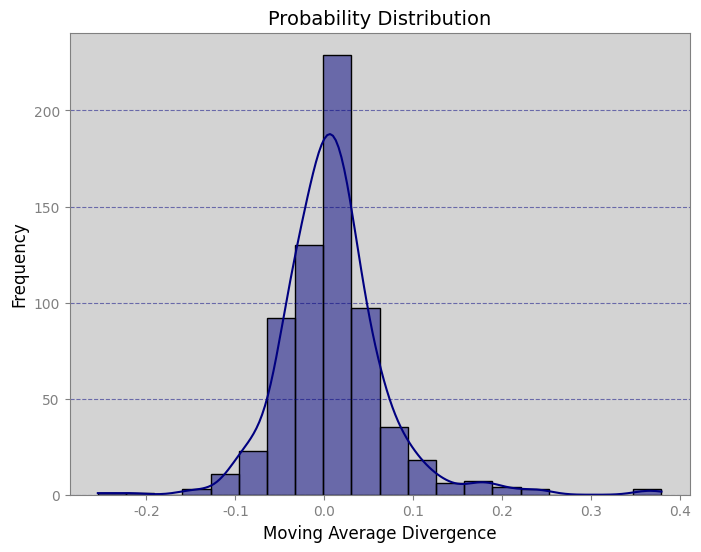

In [14]:
import seaborn as sns

# 그래프 크기 설정
plt.figure(figsize=(8, 6))

# 히스토그램 및 밀도 그래프 그리기
sns.histplot(combined_df['전봉5&10이격'], bins=20, kde=True, color = 'navy') #edgecolor='white'

# 축 레이블 및 제목 설정
plt.xlabel('Moving Average Divergence', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Probability Distribution', fontsize=14)

# 그리드 라인 추가
plt.grid(True, axis='y', color='navy', alpha=0.5, linestyle='--')

# 그래프 배경 색상 설정
plt.gca().set_facecolor('lightgray')

# 그래프 테두리 색상 설정
plt.gca().spines['top'].set_color('gray')
plt.gca().spines['right'].set_color('gray')
plt.gca().spines['bottom'].set_color('gray')
plt.gca().spines['left'].set_color('gray')

# x축 눈금 색상 설정
plt.tick_params(axis='x', colors='gray')

# y축 눈금 색상 설정
plt.tick_params(axis='y', colors='gray')

# 그래프 보여주기
plt.show()

In [ ]:
# df3Min_Infection.columns
# 필요한 컬럼 선택
columns = ['Profitable','3MA변곡', '5MA변곡', '10MA변곡',
       '20MA변곡','60MA변곡', '2VMA변곡', '5VMA변곡', '10VMA변곡', '20VMA변곡','60VMA변곡', 'VolumeChange',
       '3MA우상향', '5MA우상향', '10MA우상향', '20MA우상향','60MA우상향']

# 컬럼별로 퍼센트 계산
percentages = []
count = []
for column in columns:
    count.append(combined_df[column].sum())
    percentage = (combined_df[column].sum() / combined_df.shape[0]) * 100
    percentages.append(round(percentage,2))

# 결과를 데이터프레임으로 정리
result_df = pd.DataFrame({'Column': columns, 'Percentage(%)': percentages, 'Count':count})
result_df = result_df.sort_values('Column').reset_index(drop=True)

# 결과 출력
result_df = result_df.sort_values(by='Percentage(%)', ascending=False).reset_index(drop=True)
result_df

,Column,Percentage(%),Count
0,Profitable,100.00,720
1,60MA우상향,80.69,581
2,10MA우상향,60.83,438
3,3MA우상향,59.58,429
4,5MA우상향,56.94,410
5,20MA우상향,50.42,363
6,VolumeChange,49.72,358
7,3MA변곡,25.42,183
8,5VMA변곡,23.61,170
9,2VMA변곡,23.06,166


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPyt

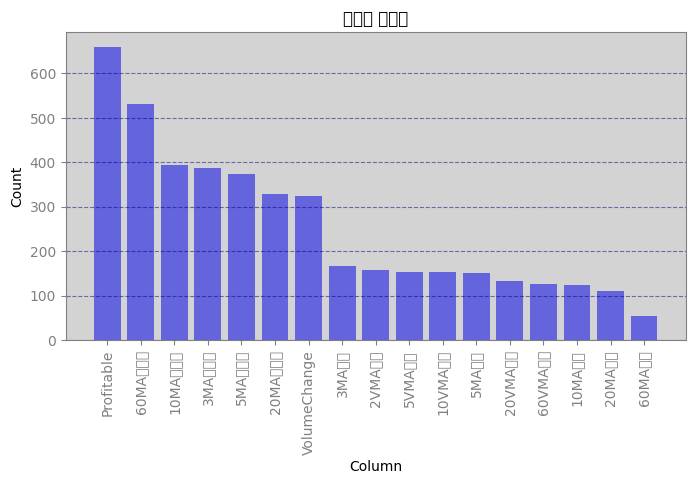

In [ ]:
df = result_df

# 그래프 크기 설정
plt.figure(figsize=(8, 4))

# 막대 그래프 그리기
plt.bar(df['Column'], df['Count'],color=(100/255, 100/255, 220/255))
plt.xlabel('Column')
plt.ylabel('Count')
plt.title('데이터 빈도수')

# X축 레이블 회전
plt.xticks(rotation='vertical')

# 그리드 라인 추가
plt.grid(True, axis='y', color='navy', alpha=0.5, linestyle='--')

# 그래프 배경 색상 설정
plt.gca().set_facecolor('lightgray')

# 그래프 테두리 색상 설정
plt.gca().spines['top'].set_color('gray')
plt.gca().spines['right'].set_color('gray')
plt.gca().spines['bottom'].set_color('gray')
plt.gca().spines['left'].set_color('gray')

# x축 눈금 색상 설정
plt.tick_params(axis='x', colors='gray')

# y축 눈금 색상 설정
plt.tick_params(axis='y', colors='gray')


# 그래프 보여주기
plt.show()

In [ ]:
df = result_df

# 그래프 크기 설정
plt.figure(figsize=(8, 4))

# 원 그래프 그리기
plt.subplot(1, 2, 2)
plt.pie(df['Percentage(%)'], labels=df['Column'], autopct='%1.1f%%')
plt.title('데이터 비율')
plt.xticks(rotation='vertical')
# 그래프 간의 간격 조정
plt.tight_layout()

# 그래프 보여주기
plt.show()

In [ ]:
pos = len(combined_df[combined_df['전봉5&10이격']>0])
neg = len(combined_df[combined_df['전봉5&10이격']<0])
print("양수 : ",pos, "음수 : ", neg)
print("d")

양수 :  246 음수 :  200
d
